In [8]:
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from target import Target
from retrieval import Retrieval
from parameters import Parameters
import figures as figs

def init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='freechem',
                   Nlive=400,tol=0.5,cloud_mode='gray',GP=True):

    brown_dwarf = Target(brown_dwarf)
    output=f'{chem}_{PT_type}_N{Nlive}_ev{tol}' # output folder name

    constant_params={} # add if needed
    free_params = {'rv': ([2,20],r'$v_{\rm rad}$'),
                'vsini': ([0,40],r'$v$ sin$i$'),
                'log_g':([3,5],r'log $g$'),
                'epsilon_limb': [(0.2,1), r'$\epsilon_\mathrm{limb}$']} # limb-darkening coefficient (0-1)

    if PT_type=='PTknot':
        pt_params={'T0' : ([1000,4000], r'$T_0$'), # bottom of the atmosphere (hotter)
                'T1' : ([0,4000], r'$T_1$'),
                'T2' : ([0,4000], r'$T_2$'),
                'T3' : ([0,4000], r'$T_3$'),
                'T4' : ([0,4000], r'$T_4$'),} # top of atmosphere (cooler)
        free_params.update(pt_params)

    if PT_type=='PTgrad':
        pt_params={'dlnT_dlnP_0': ([0.,0.4], r'$\nabla T_0$'), # gradient at T0 
                'dlnT_dlnP_1': ([0.,0.4], r'$\nabla T_1$'), 
                'dlnT_dlnP_2': ([0.,0.4], r'$\nabla T_2$'), 
                'dlnT_dlnP_3': ([0.,0.4], r'$\nabla T_3$'), 
                'dlnT_dlnP_4': ([0.,0.4], r'$\nabla T_4$'), 
                'T0': ([1000,4000], r'$T_0$')} # at bottom of atmosphere
        free_params.update(pt_params)

    # if equilibrium chemistry, define [Fe/H], C/O, and isotopologue ratios
    if chem=='equchem':
        chemistry={'C/O':([0,1], r'C/O'), 
                'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
                'log_C12_13_ratio': ([1,12], r'log $\mathrm{^{12}C/^{13}C}$'), 
                'log_O16_18_ratio': ([1,12], r'log $\mathrm{^{16}O/^{18}O}$'), 
                'log_O16_17_ratio': ([1,12], r'log $\mathrm{^{16}O/^{17}O}$')}
            
    if chem=='quequchem': # quenched equilibrium chemistry
        chemistry={'C/O':([0,1], r'C/O'), 
                'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
                'log_C12_13_ratio': ([1,12], r'log $\mathrm{^{12}C/^{13}C}$'), 
                'log_O16_18_ratio': ([1,12], r'log $\mathrm{^{16}O/^{18}O}$'), 
                'log_O16_17_ratio': ([1,12], r'log $\mathrm{^{16}O/^{17}O}$'),
                'log_Pqu_CO_CH4': ([-6,2], r'log P$_{qu}$(CO,CH$_4$,H$_2$O)'),
                'log_Pqu_NH3': ([-6,2], r'log P$_{qu}$(NH$_3$)'),
                'log_Pqu_HCN': ([-6,2], r'log P$_{qu}$(HCN)')}  
        
    # if free chemistry, define VMRs
    if chem=='freechem': 
        chemistry={'log_H2O':([-12,-1],r'log H$_2$O'),
                'log_12CO':([-12,-1],r'log $^{12}$CO'),
                'log_13CO':([-12,-1],r'log $^{13}$CO'),
                'log_C18O':([-12,-1],r'log C$^{18}$O'),
                'log_C17O':([-12,-1],r'log C$^{17}$O'),
                'log_CH4':([-12,-1],r'log CH$_4$'),
                'log_NH3':([-12,-1],r'log NH$_3$'),
                'log_HCN':([-12,-1],r'log HCN'),
                'log_HF':([-12,-1],r'log HF'),
                'log_H2(18)O':([-12,-1],r'log H$_2^{18}$O'),
                'log_H2S':([-12,-1],r'log H$_2$S')}
        
    if cloud_mode=='gray':
        cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                    'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                    'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
        free_params.update(cloud_props)

    if cloud_mode=='MgSiO3':
        cloud_props={'fsed': ([0,20], r'$f_\mathrm{sed}$'), # sedimentation parameter for particles
                    'sigma_lnorm': ([0.8,1.5], r'$\sigma_{l,norm}$'), # width of the log-normal particle distribution
                    'log_Kzz':([5,15],r'log $K_{zz}$')} # eddy diffusion parameter (atmospheric mixing)
        free_params.update(cloud_props)
        
    if GP==True: # add uncertainty scaling
        GP_params={'log_a': ([-1,1], r'$\log\ a$'), # one is enough, will be multipled with order/det error
                'log_l': ([-3,0], r'$\log\ l$')}
        free_params.update(GP_params)

    free_params.update(chemistry)
    parameters = Parameters(free_params, constant_params)
    cube = np.random.rand(parameters.n_params)
    parameters(cube)

    retrieval=Retrieval(target=brown_dwarf,parameters=parameters,
                    output_name=output,chemistry=chem,PT_type=PT_type)
    return retrieval

#retrieval=init_retrieval(brown_dwarf='2M1425',PT_type='PTgrad',chem='freechem',Nlive=300,tol=0.5)
retrieval=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='freechem',Nlive=300,tol=0.5)
#retrieval.PMN_lnL()
#only_params=['rv','vsini','log_g','T0','log_H2O','log_12CO','log_13CO','log_HF','log_H2(18)O','log_H2S']
#retrieval.evaluate(only_params=only_params,split_corner=False)
retrieval.evaluate(makefigs=False)

#retrieval2=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='equchem',Nlive=50,tol=10.0)

#retrieval2.evaluate(makefigs=False)
#figs.VMR_plot(retrieval,retrieval_object2=retrieval2)

  analysing data from /home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/2M0355/freechem_PTgrad_N300_ev0.5/pmn_.txt


In [2]:
import figures as figs
figs.VMR_plot(retrieval)

In [90]:
retrieval.final_object.pressure

array([1.00000000e-06, 1.45634848e-06, 2.12095089e-06, 3.08884360e-06,
       4.49843267e-06, 6.55128557e-06, 9.54095476e-06, 1.38949549e-05,
       2.02358965e-05, 2.94705170e-05, 4.29193426e-05, 6.25055193e-05,
       9.10298178e-05, 1.32571137e-04, 1.93069773e-04, 2.81176870e-04,
       4.09491506e-04, 5.96362332e-04, 8.68511374e-04, 1.26485522e-03,
       1.84206997e-03, 2.68269580e-03, 3.90693994e-03, 5.68986603e-03,
       8.28642773e-03, 1.20679264e-02, 1.75751062e-02, 2.55954792e-02,
       3.72759372e-02, 5.42867544e-02, 7.90604321e-02, 1.15139540e-01,
       1.67683294e-01, 2.44205309e-01, 3.55648031e-01, 5.17947468e-01,
       7.54312006e-01, 1.09854114e+00, 1.59985872e+00, 2.32995181e+00,
       3.39322177e+00, 4.94171336e+00, 7.19685673e+00, 1.04811313e+01,
       1.52641797e+01, 2.22299648e+01, 3.23745754e+01, 4.71486636e+01,
       6.86648845e+01, 1.00000000e+02])

In [89]:
retrieval.final_object.pressure[::-1]

array([1.00000000e+02, 6.86648845e+01, 4.71486636e+01, 3.23745754e+01,
       2.22299648e+01, 1.52641797e+01, 1.04811313e+01, 7.19685673e+00,
       4.94171336e+00, 3.39322177e+00, 2.32995181e+00, 1.59985872e+00,
       1.09854114e+00, 7.54312006e-01, 5.17947468e-01, 3.55648031e-01,
       2.44205309e-01, 1.67683294e-01, 1.15139540e-01, 7.90604321e-02,
       5.42867544e-02, 3.72759372e-02, 2.55954792e-02, 1.75751062e-02,
       1.20679264e-02, 8.28642773e-03, 5.68986603e-03, 3.90693994e-03,
       2.68269580e-03, 1.84206997e-03, 1.26485522e-03, 8.68511374e-04,
       5.96362332e-04, 4.09491506e-04, 2.81176870e-04, 1.93069773e-04,
       1.32571137e-04, 9.10298178e-05, 6.25055193e-05, 4.29193426e-05,
       2.94705170e-05, 2.02358965e-05, 1.38949549e-05, 9.54095476e-06,
       6.55128557e-06, 4.49843267e-06, 3.08884360e-06, 2.12095089e-06,
       1.45634848e-06, 1.00000000e-06])

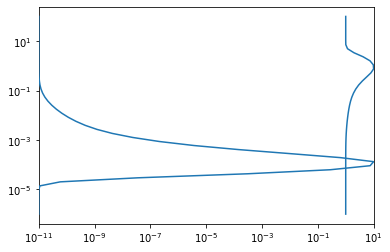

In [91]:
import matplotlib.pyplot as plt
summed_contr=np.nanmean(retrieval.final_object.contr_em_orders,axis=0) # average over all orders
xmin=1e-11
xmax=1e1
ax=plt.gca()

contribution_plot=summed_contr/np.max(summed_contr)#*(xmax-xmin)+xmin#-xmax
contribution_plot=10**contribution_plot
#print(np.max(contribution_plot))
#contribution_plot=contribution_plot/np.max(contribution_plot)#*10**(xmax-xmin)+10**xmin

#diff=np.log10(xmin)-np.min(contribution_plot)
#print(diff)
#contribution_plot-=10**diff
#plt.plot(10**contribution_plot,retrieval.final_object.pressure)
plt.plot(contribution_plot,retrieval.final_object.pressure)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(xmin,xmax)

# create new axes (set invisible) to show contribution (because it is linear-log, not log-log)
contribution_plot=summed_contr/np.max(summed_contr)*(xmax-xmin)+xmin
ax2 = ax.inset_axes([0,0,1,1]) #[x0, y0, width, height]
ax2.plot(contribution_plot,np.log10(retrieval.final_object.pressure)[::-1])
ax2.set_xlim(np.min(contribution_plot),np.max(contribution_plot))
#xax = ax2.axes.get_xaxis().set_visible(False)
#yax = ax2.axes.get_yaxis().set_visible(False)
ax2.axis('off')
ax2.set_facecolor('none')





In [5]:
bounds_array=[]
for i,key in enumerate(retrieval.parameters.param_keys):
    bounds=retrieval.parameters.param_priors[key]
    bounds_array.append(bounds)
bounds_array=np.array(bounds_array)

for sample in retrieval.posterior:
    # sample value is final/real value, need it to be between 0 and 1 depending on prior, same as cube
    cube=(sample-bounds_array[:,0])/(bounds_array[:,1]-bounds_array[:,0])
    retrieval.parameters(cube)


{'rv': 13.251379881545967, 'vsini': 3.1274246768680665, 'log_g': 4.750567970897769, 'epsilon_limb': 0.8507285185197275, 'dlnT_dlnP_0': 0.19305813316365136, 'dlnT_dlnP_1': 0.24232418548775453, 'dlnT_dlnP_2': 0.0401417955893866, 'dlnT_dlnP_3': 0.044519873875858054, 'dlnT_dlnP_4': 0.1244959219578445, 'T0': 2284.833552683572, 'log_opa_base_gray': -7.2810083263647005, 'log_P_base_gray': 2.263614533159849, 'fsed_gray': 5.7617538359940195, 'log_a': 0.2887466946291186, 'log_l': -1.7423622378549832, 'log_H2O': -2.9908148667162138, 'log_12CO': -2.704688084833764, 'log_13CO': -4.701816553326984, 'log_C18O': -5.714025522508271, 'log_C17O': -6.518076627244359, 'log_CH4': -9.371645249228543, 'log_NH3': -9.025272308373559, 'log_HCN': -10.210141197619647, 'log_HF': -6.974101923440511, 'log_H2(18)O': -5.904460579964655, 'log_H2S': -4.22977389900393}
{'rv': 13.251379881545967, 'vsini': 3.1274246768680665, 'log_g': 4.750567970897769, 'epsilon_limb': 0.8507285185197275, 'dlnT_dlnP_0': 0.19305813316365136,

In [18]:
print(retrieval2.ratios_posterior.shape)
print(retrieval2.ratios_posterior[:,-1].shape)
new=retrieval2.ratios_posterior[:,-1].reshape(len(retrieval2.ratios_posterior[:,-1]),1)
print(new.shape)
np.hstack([retrieval2.ratios_posterior,retrieval2.ratios_posterior[:,-1].reshape(len(retrieval2.ratios_posterior[:,-1]),1)])

(107, 5)
(107,)
(107, 1)


array([[ 0.52175356,  0.66037668,  1.91633226,  9.02160183,  7.72590861,
         7.72590861],
       [ 0.52028478,  0.58446491,  2.02120922, 10.37554358,  8.60856657,
         8.60856657],
       [ 0.53610416,  0.62545913,  1.96774389,  7.97387528,  9.01895404,
         9.01895404],
       [ 0.52593023,  0.59953684,  2.09597792,  9.59677278,  9.32718463,
         9.32718463],
       [ 0.51371697,  0.61502261,  1.98659259, 11.62518519, 10.31740733,
        10.31740733],
       [ 0.52448206,  0.58229073,  2.01968506,  8.5305307 ,  8.35346563,
         8.35346563],
       [ 0.52607395,  0.60607233,  2.01216367,  8.62637231,  8.73316106,
         8.73316106],
       [ 0.51786306,  0.65254301,  2.02562804,  8.30268991,  8.51505603,
         8.51505603],
       [ 0.52091924,  0.58341387,  2.03297607,  4.6223853 ,  3.96837934,
         3.96837934],
       [ 0.52392454,  0.59903513,  2.10620738,  8.59183144,  6.39894986,
         6.39894986],
       [ 0.51900554,  0.57889237,  1.96629946, 10.

In [8]:
import pickle
import pathlib
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N300_ev0.5/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)
# print S/N + sigma for latex table
for molecule in ['13CO','HF','H2S','H2(18)O']:
    SNR=np.round(final_params[f'SNR_{molecule}'],decimals=2)
    sigma=np.round(final_params[f'sigma_{molecule}'],decimals=2)
    print(SNR,'\&',sigma,'\\\\')

5.11 \& 4.11 \\
4.69 \& 3.82 \\
-0.08 \& 3.49 \\
1.11 \& -1.79 \\


In [ ]:
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/test/freechem_PTgrad_N100_ev5.0/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)
final_params#['sigma_13CO']

# Make plots for presentation

In [ ]:
import getpass
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when runnig from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    os.environ['OMP_NUM_THREADS'] = '1' # important for MPI
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    from atm_retrieval.target import Target
    from atm_retrieval.likelihood import Retrieval
    from atm_retrieval.parameters import Parameters
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from likelihood import Retrieval
    from parameters import Parameters
    from pRT_model import pRT_spectrum


M0355 = Target('2M0355')
data_wave,data_flux,data_err=M0355.load_spectrum()

constant_params = {'vsini': 2, # rotational velocity
                'rv': 11.92,
                'log_Kzz': 7.5, # eddy diffusion parameter (atmospheric mixing)
                'fsed': 2, # sedimentation parameter for particles
                'P_base_gray': 1, # pressure of gray cloud deck
                'fsed_gray': 2,
                'opa_base_gray': 0.8, # opacity of gray cloud deck
                'sigma_lnorm': 1.05, # width of the log-normal particle distribution of MgSiO3
                'log_MgSiO3' : 0, # scaling wrt chem equilibrium, 0 = equilibrium abundance 
                'log_H2O': -2.9,#-2.9,
                'log_12CO': -2.67,#-2.66,
                'log_13CO':-4.9,
                'log_C18O':-12, #-8.3,
                'log_C17O':-12,  #-8.7,
                'log_CH4':-12, #-8.6,
                'log_NH3':-12, #-8.9,
                'log_HCN':-12, #-8,
                'T1' : 2500, # bottom of the atmosphere (hotter)
                'T2' : 1500,
                'T3' : 1270,
                'T4' : 313, # top of atmosphere (cooler)
                'log_g':4.95,
                } 

free_params = {}
parameters = Parameters(free_params,constant_params)
params=parameters.params


output='2M0355_test4'
retrieval=Retrieval(target=M0355,parameters=parameters,output_name=output)
atmosphere_objects=retrieval.atmosphere_objects

species=retrieval.get_species(param_dict=parameters.params)
model_flux=pRT_spectrum(parameters=params,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()


In [ ]:
params_H2O=params.copy()
params_H2O['log_12CO']=-12
params_H2O['log_13CO']=-12
H2O_flux=pRT_spectrum(parameters=params_H2O,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

params_CO=params.copy()
params_CO['log_H2O']=-12
params_CO['log_13CO']=-12
CO_flux=pRT_spectrum(parameters=params_CO,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(7,3),dpi=200,sharex=True)
order=5
det=0
for i in range(2):
    ax[i].plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
    ax[i].set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
    ax[i].yaxis.set_visible(False) # remove ylabels because anyway unitless

ax[0].plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
ax[1].plot(data_wave[order,det],H2O_flux[order,det],lw=1,alpha=0.8,c='tab:blue',label='H$_2$O')
ax[1].plot(data_wave[order,det],CO_flux[order,det],lw=1,alpha=0.8,c='tab:orange',label='CO')

ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)
ax[1].set_xlabel('Wavelength [nm]')
fig.tight_layout(h_pad=-0.1)
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/spectrum.jpg')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/model.jpg')

In [ ]:
params_bad=params.copy()
params_bad['log_H2O']=-3.5
params_bad['log_CO']=-2
params_bad['vsini']=7
params_bad['T1']=1700
bad_flux=pRT_spectrum(parameters=params_bad,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],bad_flux[order,det],lw=1,alpha=1,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/bad_model1.jpg')